In [1]:
dataset <- "Dext3r" # Dext3r has all the series. They should be integrated, however
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Emilia-Romagna"
match_dist <- 10000
new_dataset <- "ER"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    # filter(is.na(state) | state == "Emilia-Romagna") |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    filter(!(dataset == "SCIA" & sensor_key %in% c(349L))) |> # Bologna
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = 10000) |>
    st_drop_geometry() |>
    filter(
        !state %in% c("Piemonte", "Lombardia", "Toscana", "Veneto", "Marche", "Liguria", "Umbria") | is.na(state),
        network != "DPC",
        dataset != "SCIA" |
            network %in% c("Sinottica", "Mareografica") |
            (dataset == "SCIA" & sensor_key %in% c(3183L, 3135L, 3116L)), # ??
            !(dataset == "SCIA" & sensor_key %in% c(2708L, 2906L)) # Parma e Punta marina sinottiche
    ) 
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    filter(!(dataset == "SCIA" & sensor_key %in% c(1388L, 678L, 2114L))) # Ferrara Synop, Casalecchio Synop, Modena Synop
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db)
analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))
# analysis <- read_parquet(file.path("notebooks", "ds_regionali", "emilia-romagna", "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    mutate(tag_mergeable = TRUE) |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"), starts_with("series_id"), starts_with("tag_"))


In [6]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(
    gs$table,
    metadata |> mutate(network_prio = if_else(network == "ISAC", 2L, 1L)),
    merging_datasets,
    desc(dataset), desc(sensor_last)
)
ignore_corrections <- NULL #make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 15L, 0.5, ignore_corrections)


In [7]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,sensor_key_x,name_y,network_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
17,-1.52267596,-1.2423811,-0.08508962,-0.002721712,78,199,197,-1,-1,Ferrara urbana,urbane,562,Ferrara,idrost,560
269,1.92462397,0.3576315,-0.11081952,-0.073802261,135,364,365,-1,-1,Novafeltria,simnbo,995,Novafeltria,idrost,996
35,-0.54769575,-1.7104521,-0.04938245,-0.130428465,110,296,647,-1,1,Marina di Ravenna,claster,815,Ravenna,Mareografica,3264
32,-0.47032689,-1.7400702,-0.04861002,-0.005051672,94,248,247,1,-1,Imola,simnbo,698,Imola,idrost,696
418,-1.48957055,0.0000000,0.00000000,0.000000000,209,595,594,1,-1,Verghereto,simnbo,1679,Verghereto,idrost,1678
215,-1.04868702,-0.6393721,0.04228991,-0.108360233,108,286,294,-1,1,MALBORGHETTO,locali,790,Malborghetto di Boara,profe,807
18,-1.71581276,0.4557332,0.19135042,-0.042060301,78,199,197,1,0,Ferrara urbana,urbane,562,Ferrara,idrost,560
136,-1.02050915,-0.4353328,-0.17693564,0.107074327,68,180,620,1,0,Diga di Brasimone,claster,521,diga del Brasimone,idrost,1743
49,-3.24458112,3.2310690,0.40036172,0.371240008,165,457,452,-1,0,Rimini urbana,urbane,1304,Rimini,idrost,1294


In [8]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 100, ignore_corrections, contribution_threshold = -1L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations, series_groups = gs$table)
rm(merge_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2173697,116.1,3661010,195.6,NA,3661010,195.6
Vcells,26038994,198.7,112355012,857.3,16384,182763775,1394.4


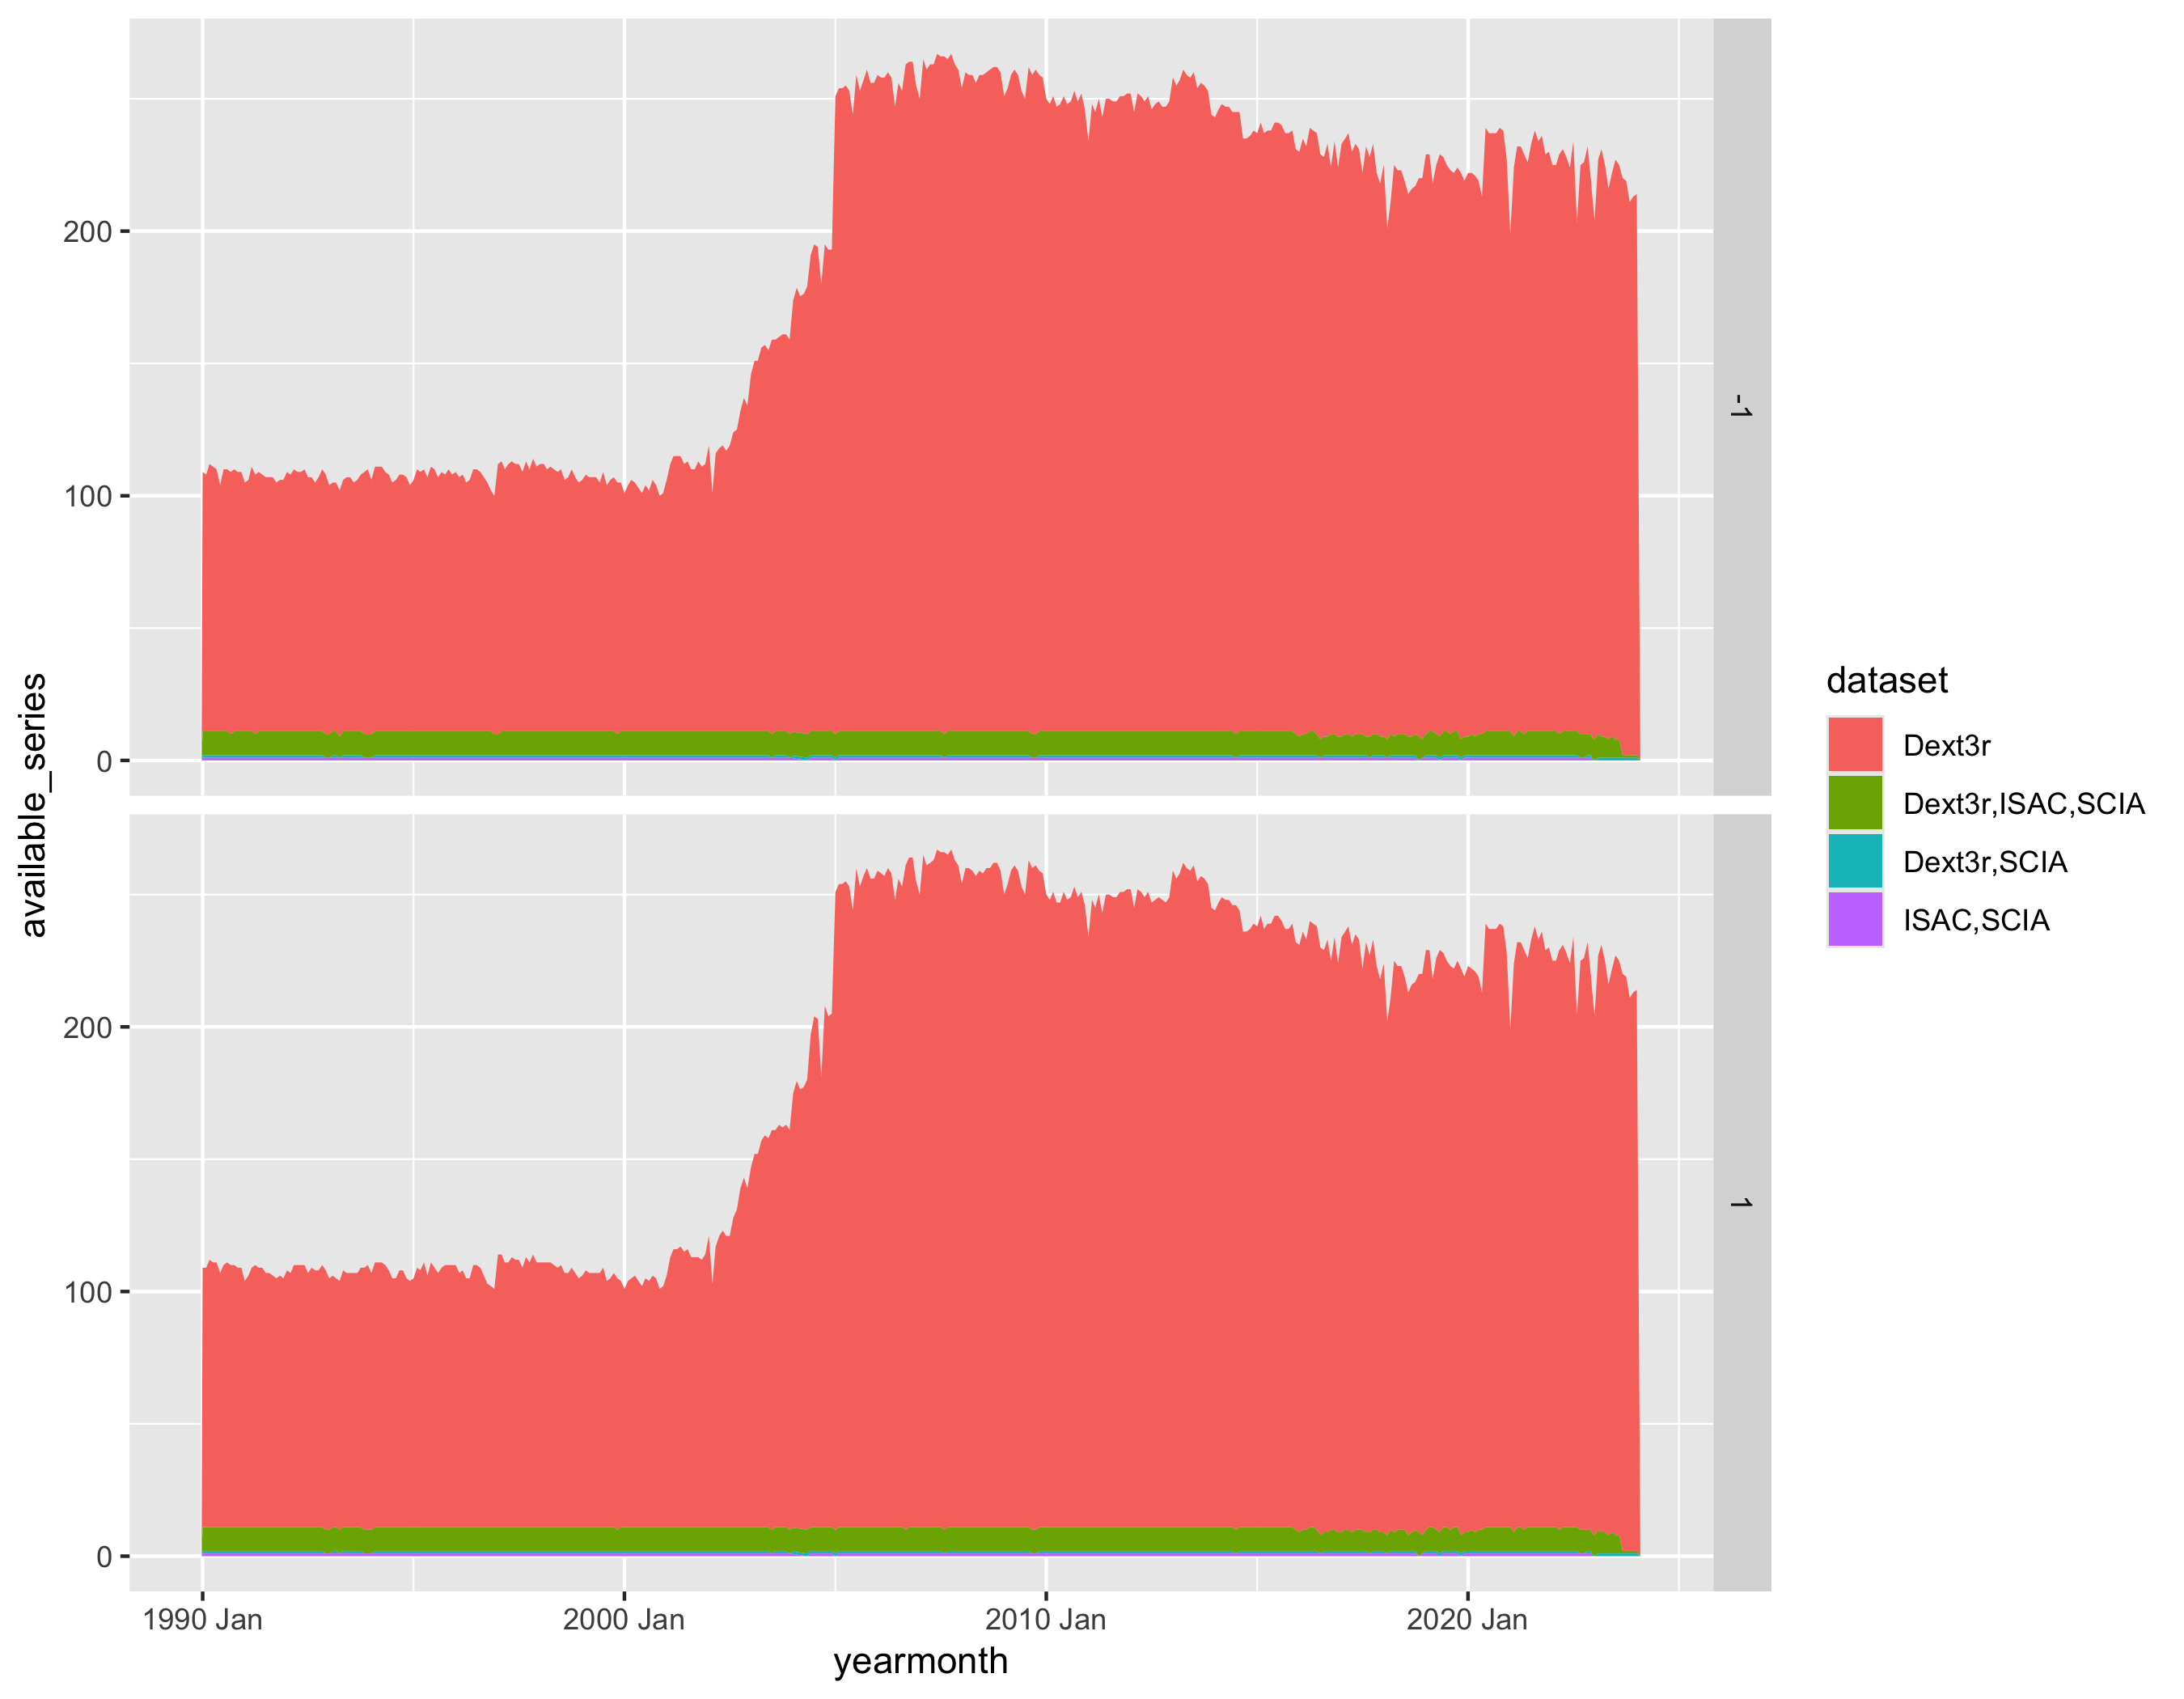

In [9]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = T)
pd$plot + facet_grid(variable ~ .)


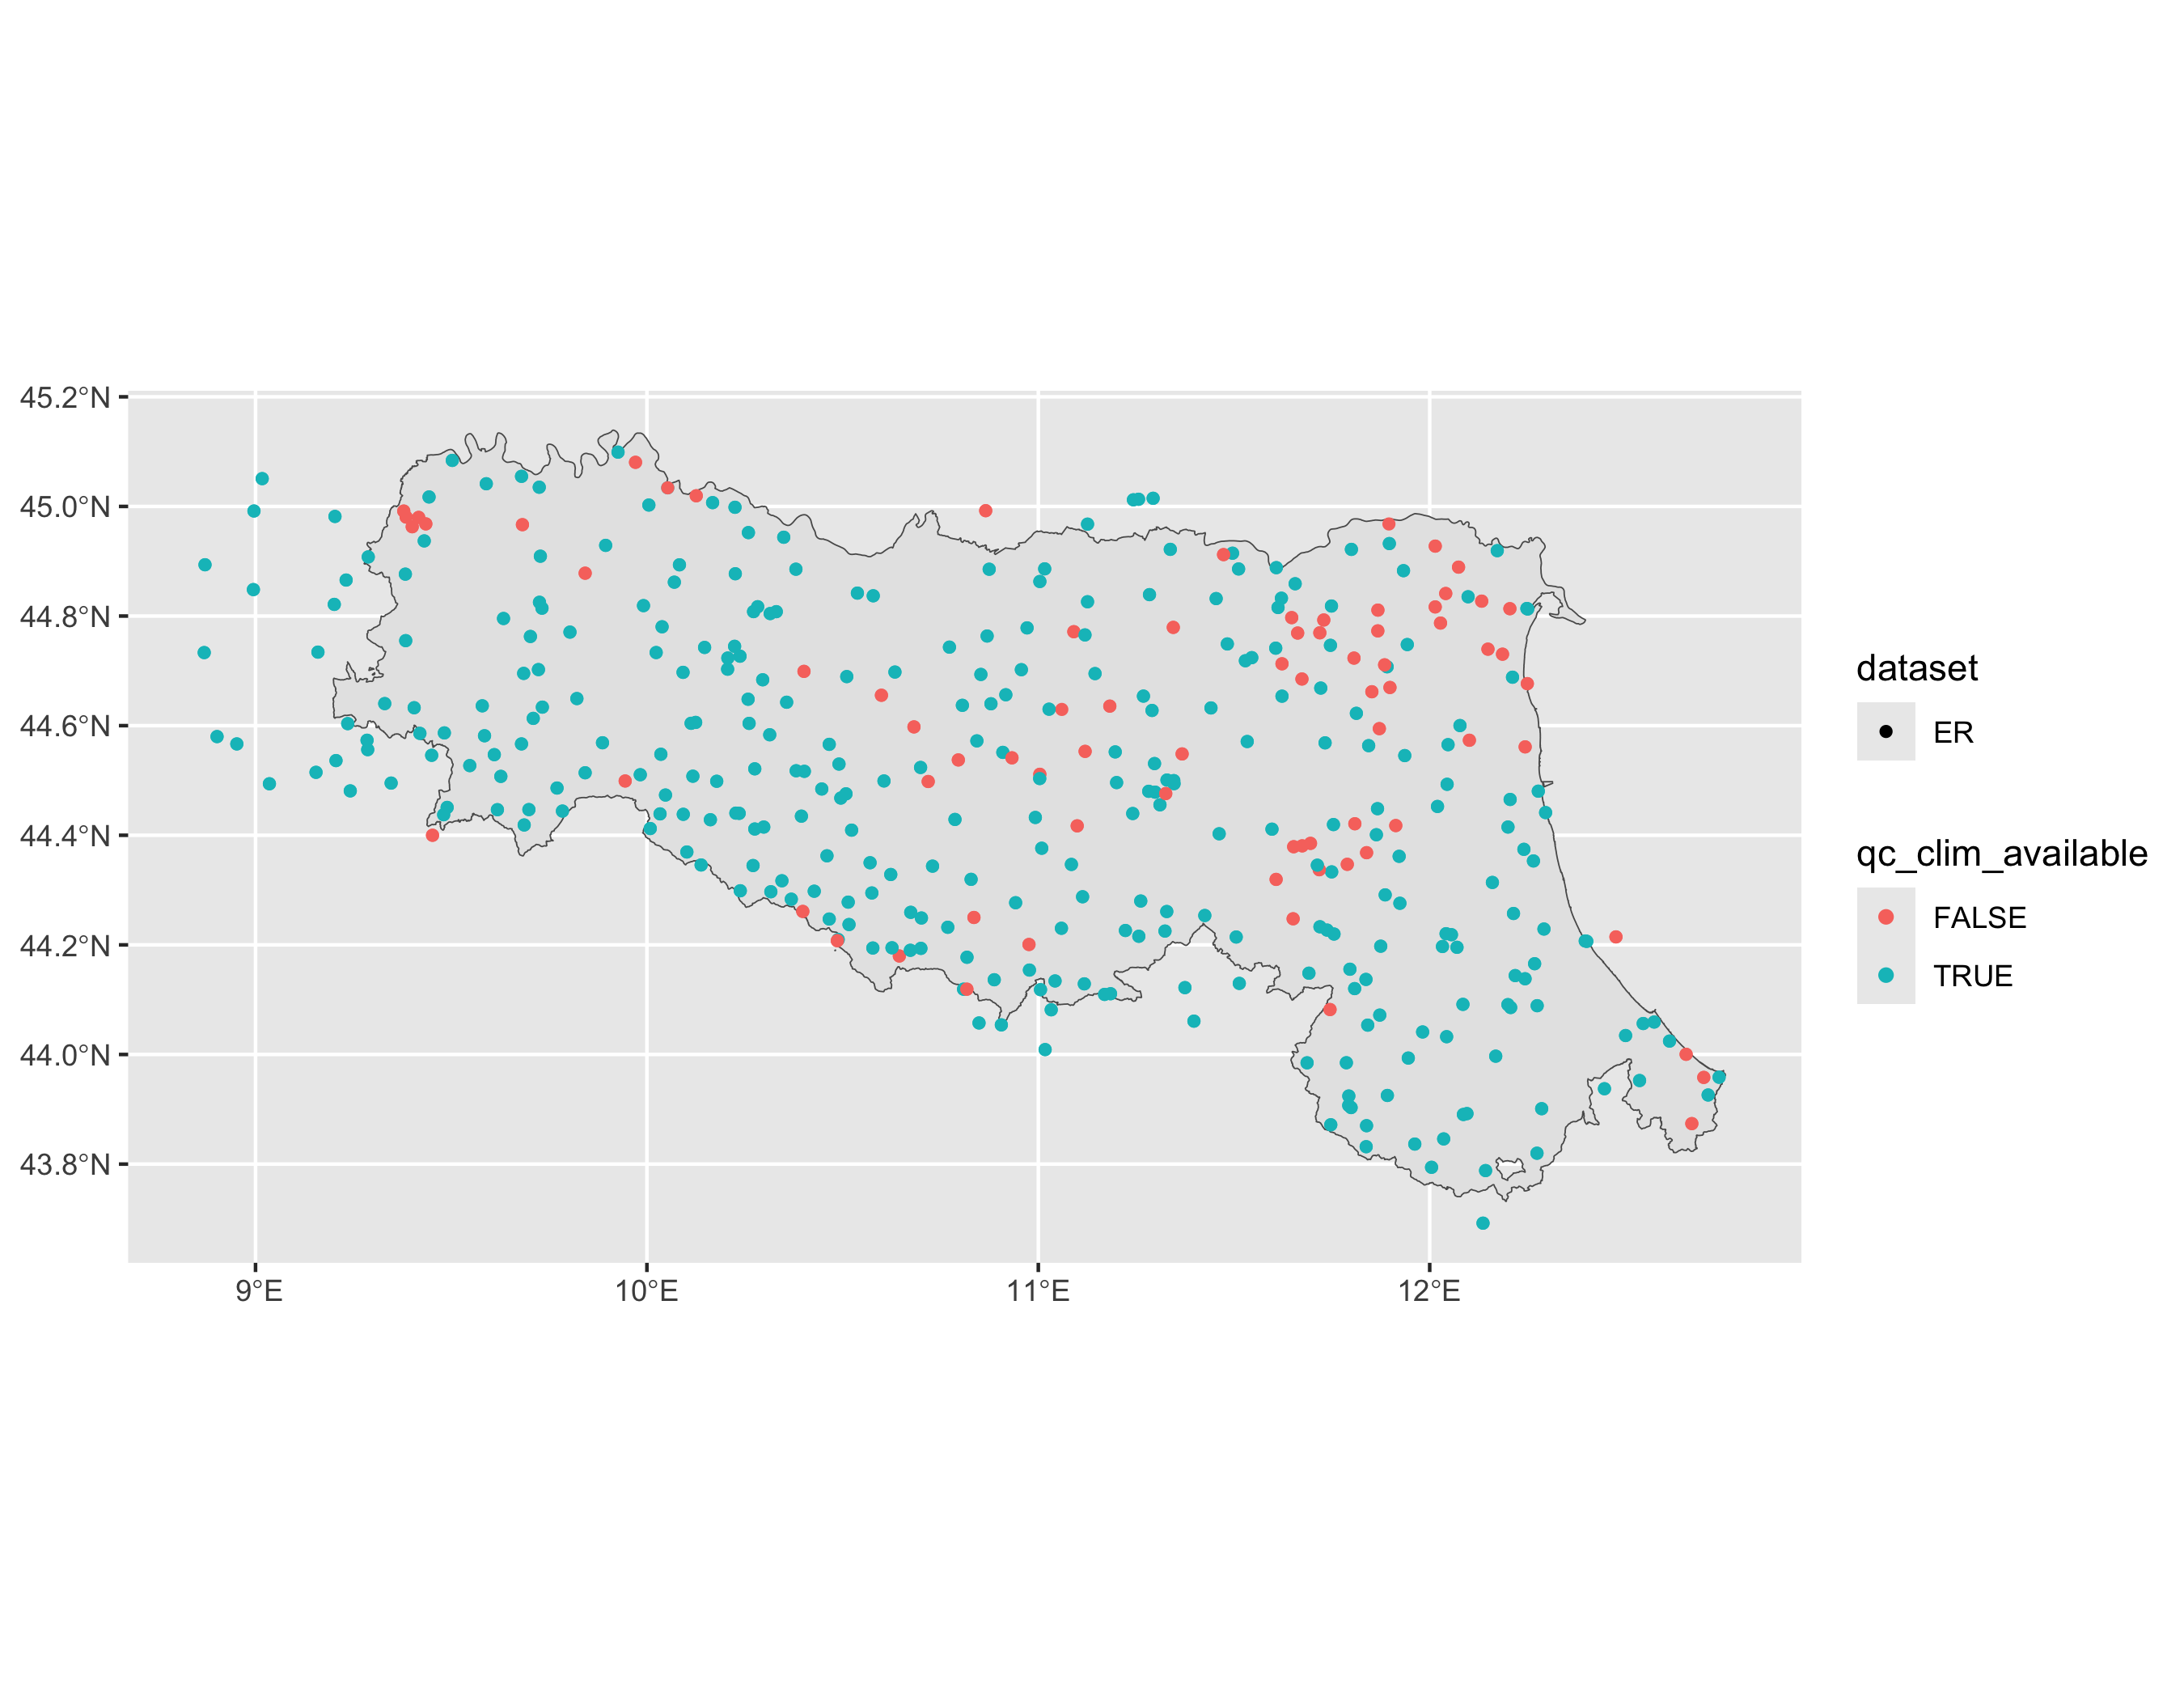

In [10]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot


In [11]:
pd$data |>
    group_by(qc_clim_available, variable) |>
    count() |>
    arrange(qc_clim_available, variable)


qc_clim_available,variable,n
<lgl>,<int>,<int>
FALSE,-1,80
FALSE,1,81
TRUE,-1,321
TRUE,1,322


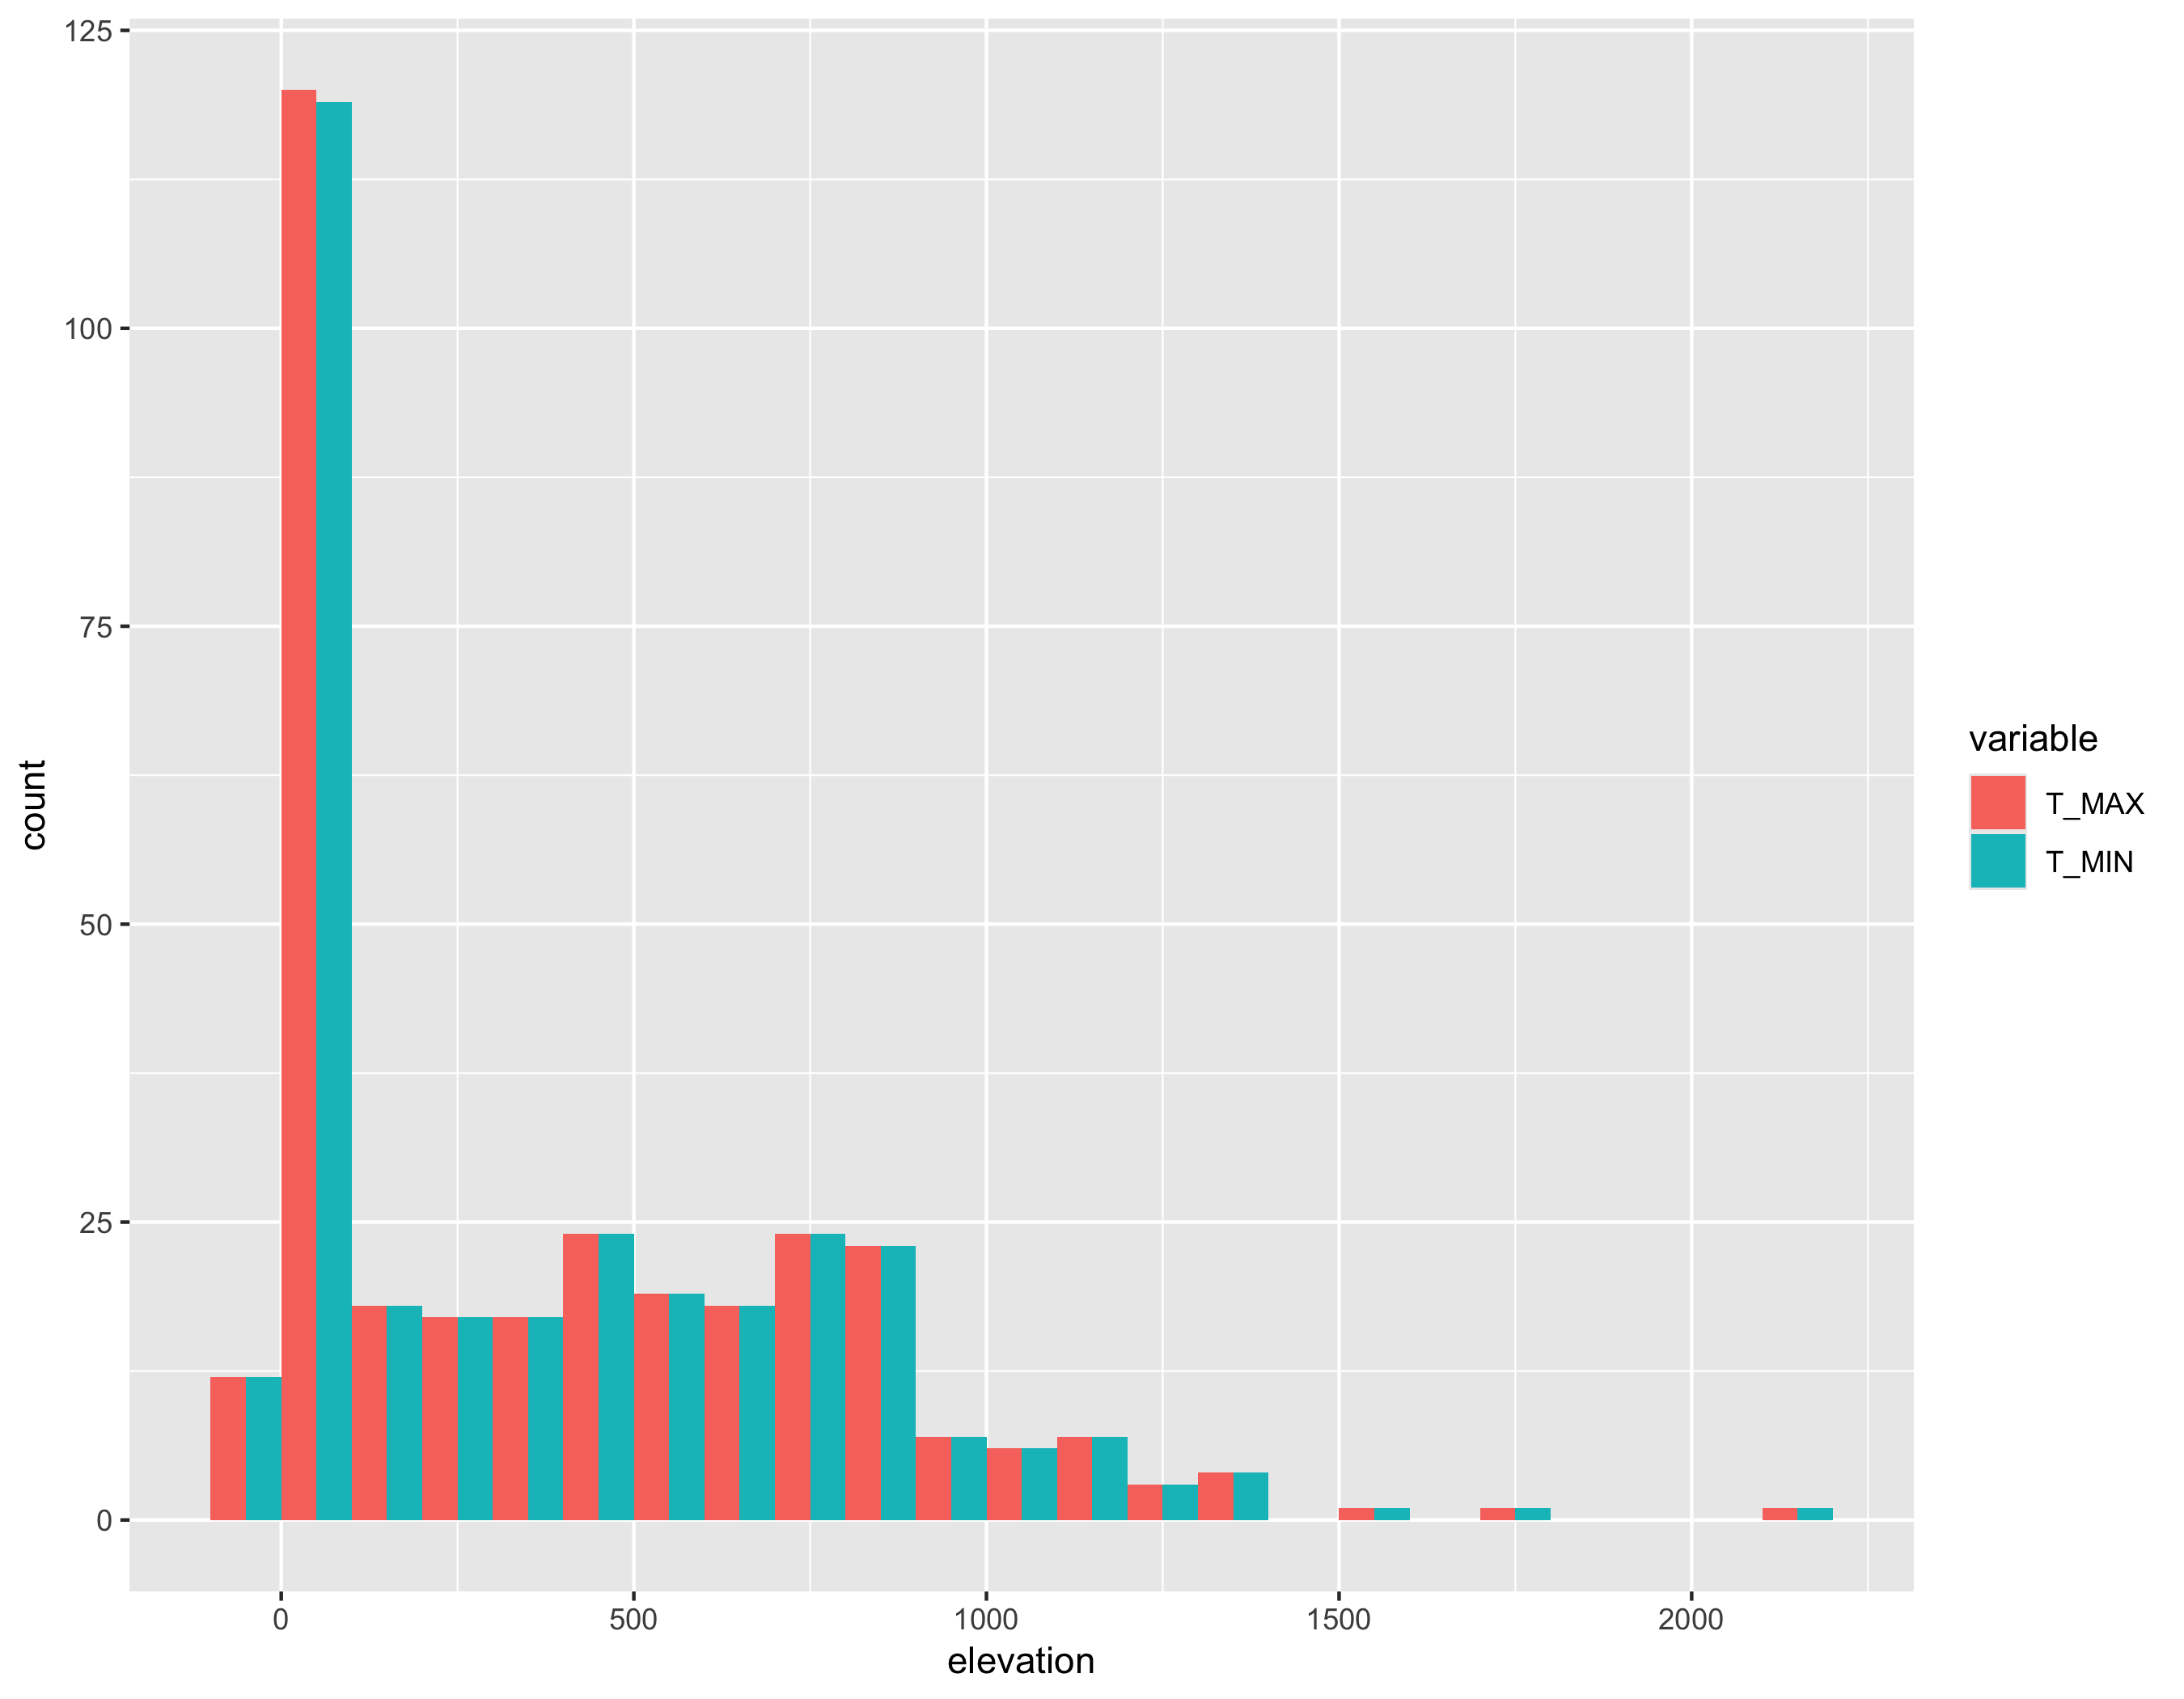

In [12]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())
